В этой тетрадке я строил классификатор для текстов с использованием самых базовых методов.

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data


Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [ ]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('train.csv')

In [ ]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Обработка пропусков

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [ ]:
data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
data = data.fillna("")

в train и test заполнил пропуски в след. заданиях

## Визуализация и базовый анализ


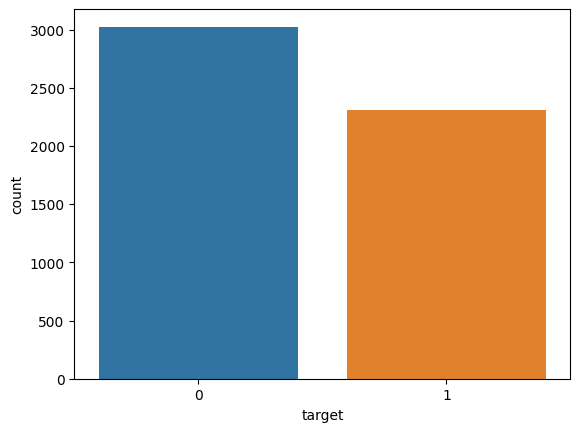

In [ ]:
# -- YOUR CODE HERE --
sns.countplot(x='target', data=train)
plt.show()

В обучающей выборке больше примеров класса 0

In [ ]:
popular_keywords = train['keyword'].value_counts().head(10).index.tolist()
popular_keywords

['damage',
 'siren',
 'wreckage',
 'fatalities',
 'deluge',
 'twister',
 'fatality',
 'harm',
 'emergency',
 'nuclear%20reactor']

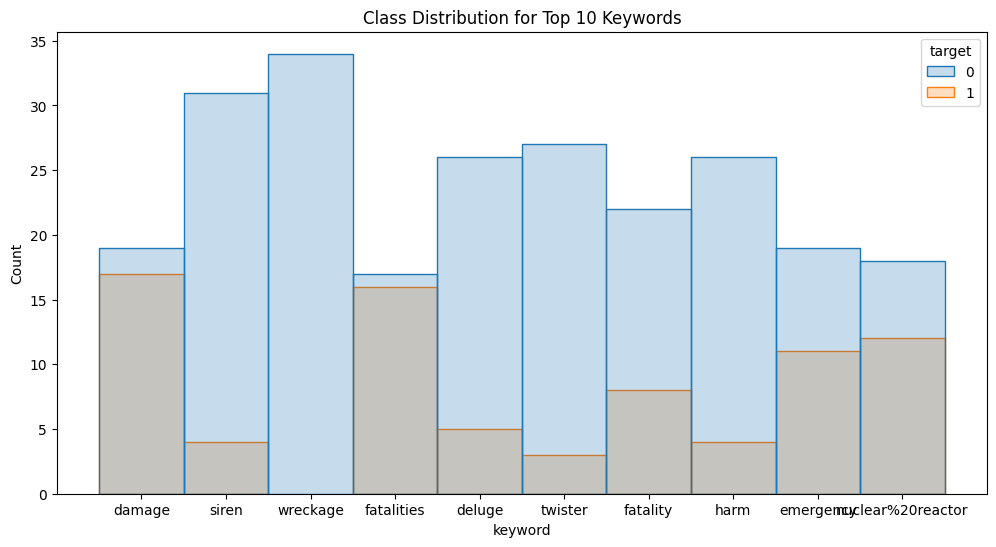

In [ ]:
plt.figure(figsize=(12,6))

for keyword in popular_keywords:
    data_i = train[(train['keyword'] == keyword)]
    sns.histplot(data=data_i, x='keyword', hue = 'target', multiple = 'layer', element = 'step', discrete = False)

plt.title('Class Distribution for Top 10 Keywords')
plt.ylabel('Count')
plt.show()


**Выводы**: Видим, что класс 0 преобладает среди топ-10 наиболее  встречающихся значений, оранжевого цвета не видно вообще

## Сконкатим для удобства все текстовые столбцы в один

In [ ]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,NaN,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [ ]:
train_new = train.copy()
train_new[['keyword', 'location']] = train_new[['keyword', 'location']].fillna('')
train_new['text'] = train_new['keyword'] + ' ' + train_new['location'] + ' ' + train_new['text']
train_new = train_new.drop(columns=['id', 'keyword', 'location'])

test_new = test.copy()
test_new[['keyword', 'location']] = test_new[['keyword', 'location']].fillna('')
test_new['text'] = test_new['keyword'] + ' ' + test_new['location'] + ' ' + test_new['text']
test_new = test_new.drop(columns=['id', 'keyword', 'location'])

In [ ]:
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


In [ ]:
test_new.head(10)

,text,target
2644,destruction So you have a new weapon that can...,1
2227,deluge The f$&amp;@ing things I do for #GISHW...,0
5448,police UK DT @georgegalloway: RT @Galloway4May...,1
132,aftershock Aftershock back to school kick off...,0
6845,"trauma Montgomery County, MD in response to tr...",0
5559,rainstorm @Calum5SOS you look like you got ca...,0
1765,collision my favorite lady came to our volunt...,1
1817,crashed @brianroemmele UX fail of EMV - peopl...,1
6810,"tragedy Los Angeles, CA Can't find my ariana g...",0
4398,"hijacking Athens,Greece The Murderous Story Of...",1


## Векторизация с помощью CountVectorizer


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# -- YOUR CODE HERE --
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train_new['text'])
print("Размерность матрицы:", X.shape)


Размерность матрицы: (5329, 18455)


получилась достаточно большая матрица. Если посмотреть на текст, то можно увидеть, что там есть множество специальных символов, ссылок и прочего мусора.

Посмотрим на словарь  CountVectorizer'а и ответим на след вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось?

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [ ]:
import re

def contains_digit(s: str) -> bool:
    # Проверка, содержит ли слово цифры
    return bool(re.search(r'\d', s))

def contains_punctuation(s: str) -> bool:
    # Проверка, содержит ли слово пунктуацию
    return any(i in punctuation for i in s)

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s.startswith('#')

def is_mention(s: str) -> bool:
    # Проверка, является ли слово упоминанием
    return s.startswith('@')

def investigate_vocabulary(vocabulary):
    digits = sum(contains_digit(word) for word in vocabulary)
    punctuation = sum(contains_punctuation(word) for word in vocabulary)
    hashtags = sum(is_hashtag(word) for word in vocabulary)
    mentions = sum(is_mention(word) for word in vocabulary)

    print('Digits - ', digits)
    print('Punctuation - ', punctuation)
    print('Hashtags - ', hashtags)
    print('Mentions - ', mentions)

In [ ]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

Digit -  2
Punctuation -  7
Hashtags -  1
Mentions -  3


In [ ]:
investigate_vocabulary(vectorizer.vocabulary_)

Digit -  3812
Punctuation -  315
Hashtags -  0
Mentions -  0


в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором.

In [ ]:
from nltk.tokenize import TweetTokenizer

In [ ]:
vectorizer_tweet = CountVectorizer(tokenizer=TweetTokenizer().tokenize, token_pattern = "None")
X_tweet = vectorizer_tweet.fit_transform(train_new['text'])

In [ ]:
investigate_vocabulary(vectorizer_tweet.vocabulary_)

Digit -  3939
Punctuation -  7338
Hashtags -  1470
Mentions -  1679


**Сравнение:**

- Использование `TweetTokenizer` приводит к увеличению количества слов, содержащих цифры и пунктуацию.

- Без использования `TweetTokenizer` хэштеги и упоминания не распознаются как отдельные токены.


## Кастомный токенайзер

напишем кастомный токенайзер, которые сделает все, что нам нужно:

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from typing import List

In [ ]:
def contains_only_latin_letters(s: str) -> bool:
    # Проверка, содержит ли слово только латинские буквы
    return all(i.isalpha() and i.isascii() for i in s)

def is_emoji(s: str) -> bool:
    # Проверка, является ли слово смайликом
    return all((i in punctuation or i in "()") for i in s) and (("(" in s) or (")" in s))

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s.startswith("#") and contains_only_latin_letters(s[1:])

def custom_tokenizer(s: str) -> List[str]:
    # Кастомный токенайзер
    s = s.lower()
    tweet_tokenizer = TweetTokenizer()
    tokens = tweet_tokenizer.tokenize(s)
    stemmer = SnowballStemmer("english")
    stpwrds = stopwords.words('english')

    result = []
    for token in tokens:
        if contains_only_latin_letters(token) or is_emoji(token) or is_hashtag(token):
            if token not in stpwrds:
                result.append(stemmer.stem(token))

    return result


In [ ]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Тестим

In [ ]:
smpl = train['text'].head(10)

tokenized_texts = smpl.apply(custom_tokenizer)

for original_text, tokenized_text in zip(smpl, tokenized_texts):
    print(f"Original text: {original_text}")
    print(f"Tokenized text: {tokenized_text}")
    print("\n")


Original text: Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0
Tokenized text: ['ash', 'australia', 'collaps', 'trent', 'bridg', 'among', 'worst', 'histori', 'england', 'bundl', 'australia']


Original text: GREAT MICHIGAN TECHNIQUE CAMP
B1G THANKS TO @bmurph1019 
@hail_Youtsey . @termn8r13 
#GoBlue #WrestleOn http://t.co/OasKgki6Qj
Tokenized text: ['great', 'michigan', 'techniqu', 'camp', 'thank', '#goblu', '#wrestleon']


Original text: CNN: Tennessee movie theater shooting suspect killed by police http://t.co/dI8ElZsWNR
Tokenized text: ['cnn', 'tennesse', 'movi', 'theater', 'shoot', 'suspect', 'kill', 'polic']


Original text: Still rioting in a couple of hours left until I have to be up for class.
Tokenized text: ['still', 'riot', 'coupl', 'hour', 'left', 'class']


Original text: Crack in the path where I wiped out this morning during beach run. Surface wounds on left elbow and right knee. h

1. Все слова, которые не передают смысловой нагрузки, были удалены. Например, во втором тексте "B1G THANKS TO @bmurph1019 @hail_Youtsey . @termn8r13" было сокращено до "thank".

2. Все слова были приведены к нижнему регистру

3. Слова были преобразованы к их базовой форме. Например, "wound" вместо "wounded".

4. В некоторых случаях были удалены или заменены последние буквы слов. Например, collapse - collaps, really - realli, house - hous



## Применим векторайзер с новым токенизатором и обучим классификатор



In [ ]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer)

X_train = vectorizer.fit_transform(train_new['text'])
X_test = vectorizer.transform(test_new['text'])

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train, train_new['target'])
y_pred = lr.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(test_new['target'], y_pred)
print(f'F1 Score on test data: {f1}')

F1 Score on test data: 0.752953813104189


## Пробуем с TF-IDF



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
X_train_tf = vectorizer.fit_transform(train_new['text'])
X_test_tf = vectorizer.transform(test_new['text'])

lr_tf = LogisticRegression(random_state=42, max_iter=1000)
lr_tf.fit(X_train_tf, train_new['target'])
y_pred_tf = lr_tf.predict(X_test_tf)

f1_tf = f1_score(test_new['target'], y_pred_tf)
print(f'F1 Score on test data: {f1_tf}')


F1 Score on test data: 0.7422222222222221


1.
F1 score стало чуть меньше, в отличие от CountVectorizer

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто.

In [ ]:
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9)
X_train_tf2 = vectorizer.fit_transform(train_new['text'])
X_test_tf2 = vectorizer.transform(test_new['text'])

lr_tf2 = LogisticRegression(random_state=42, max_iter=1000)
lr_tf2.fit(X_train_tf2, train_new['target'])
y_pred_tf2 = lr_tf2.predict(X_test_tf2)

f1_tf2 = f1_score(test_new['target'], y_pred_tf2)
print(f'F1-Score on test data: {f1_tf2}')

F1-Score on test data: 0.7422222222222221


In [ ]:
X_train_tf.shape

(5329, 10482)

In [ ]:
X_train_tf2.shape

(5329, 10482)

Ничего не поменялось

Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df.

In [ ]:
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9, min_df=0.005)
X_train_tf3 = vectorizer.fit_transform(train_new['text'])
X_test_tf3 = vectorizer.transform(test_new['text'])

lr_tf3 = LogisticRegression(random_state=42, max_iter=1000)
lr_tf3.fit(X_train_tf3, train_new['target'])
y_pred_tf3 = lr_tf3.predict(X_test_tf3)

f1_tf3 = f1_score(test_new['target'], y_pred_tf3)
print(f'F1-Score: {f1_tf3}')

F1-Score: 0.7190889370932756


In [ ]:
X_train_tf3.shape

(5329, 394)

размерность очень сильно уменьшилась

результат ухудшается с уменьшением min_df.при таких ограничениях мы удалили слишком много слов, которые были полезны для классификации.


Итого, кастомный векторайзер топчик